In [406]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from string import punctuation

In [407]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split

In [408]:
### LOADING DATA ###
# taken from Kaggle
rev = pd.read_csv('Restaurant_Reviews.tsv',sep='\t')

print(rev.head())
print(rev.shape)
print(rev.dtypes)
# Liked = 1 means positive and Liked = 0 means negative

                                              Review  Liked
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1
(1000, 2)
Review    object
Liked      int64
dtype: object


In [409]:
### DATA PROCESSING ###

# 1. Lower Case  Connversion
rev['Review'] = rev['Review'].apply(lambda x: x.lower())
print(rev.head())
print('\n')

# 2. Removing Punctuation
print('punctuations to be removed:', punctuation)
print('\n')
rev['Review'] = rev['Review'].apply(lambda x: ''.join([w for w in x if w not in punctuation]))
print(rev.head())

# # 3. Removing STOPWORDS
# import nltk
# # nltk.download('stopwords')
# from nltk.corpus import stopwords
# stoplist = stopwords.words('english')

# rev['Review'] = rev['Review'].apply(lambda x: ' '.join([w for w in x.split() if w not in stoplist]))
# print(rev.head())

                                              Review  Liked
0                           wow... loved this place.      1
1                                 crust is not good.      0
2          not tasty and the texture was just nasty.      0
3  stopped by during the late may bank holiday of...      1
4  the selection on the menu was great and so wer...      1


punctuations to be removed: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


                                              Review  Liked
0                               wow loved this place      1
1                                  crust is not good      0
2           not tasty and the texture was just nasty      0
3  stopped by during the late may bank holiday of...      1
4  the selection on the menu was great and so wer...      1


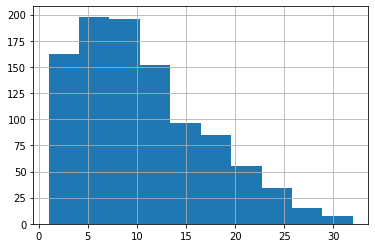

count    1000.000000
mean       10.847000
std         6.236865
min         1.000000
25%         6.000000
50%        10.000000
75%        15.000000
max        32.000000
dtype: float64


In [410]:
### Max Length of review to be used
# checking on review length
word_len = [len(x) for x in rev['Review'].str.split()]
pd.Series(word_len).hist()
plt.show()
print(pd.Series(word_len).describe())

word_len = 35 # assumed for now 

In [411]:
vocab_max = 2500

In [412]:
### Tokenizing and creating sequences of fixed seq. word_len 
# review less than seq length will be padded and more than seq length will be truncated
tokenizer = Tokenizer(num_words =  vocab_max, split=" ")
tokenizer.fit_on_texts(rev['Review'].values)
X = tokenizer.texts_to_sequences(rev['Review'].values)
X = pad_sequences(X, maxlen=word_len)

In [413]:
print(X.shape)
print(X)

(1000, 35)
[[  0   0   0 ... 162   8  15]
 [  0   0   0 ...   7  12  16]
 [  0   0   0 ...   4  45 425]
 ...
 [  0   0   0 ...  12  38  31]
 [  0   0   0 ... 136 157  40]
 [  0   0   0 ... 347   1 275]]


In [414]:
### Model Building

embedding_dim = 25 #hyper-parameter
lstm_cell = 128 #hyper-parameter

model = Sequential()
model.add(Embedding(word_max, embedding_dim, input_length = X.shape[1]))
model.add(LSTM(lstm_cell, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 35, 25)            62500     
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               78848     
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 258       
Total params: 141,606
Trainable params: 141,606
Non-trainable params: 0
_________________________________________________________________
None


In [415]:
### Train-Test Splitting

y = pd.get_dummies(rev['Liked']).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 4)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 35) (800, 2)
(200, 35) (200, 2)


In [416]:
### Model fit 
# batcch size and n_epochs are hyper-parameters
batch_size = 16
n_epochs = 5
model.fit(X_train, y_train, epochs = n_epochs, batch_size=batch_size, verbose = 2)

Epoch 1/5
 - 2s - loss: 0.6926 - accuracy: 0.5163
Epoch 2/5
 - 1s - loss: 0.6168 - accuracy: 0.7400
Epoch 3/5
 - 1s - loss: 0.3768 - accuracy: 0.8675
Epoch 4/5
 - 1s - loss: 0.2523 - accuracy: 0.9187
Epoch 5/5
 - 1s - loss: 0.1321 - accuracy: 0.9688


In [417]:
loss, accuracy = model.evaluate(X_test, y_test, verbose = 2, batch_size = batch_size)
print("Loss: %.2f" % (loss))
print("Accuracy: %.2f" % (accuracy))

Loss: 0.55
Accuracy: 0.75
